In [2]:
# Add the source directory to the Python path
import sys
sys.path.append('../src')

In [3]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

from task_3_credit_risk_analysis import load_loan_data


In [9]:
# Load data
df = load_loan_data('../data/Task 3 and 4_Loan_Data.csv')

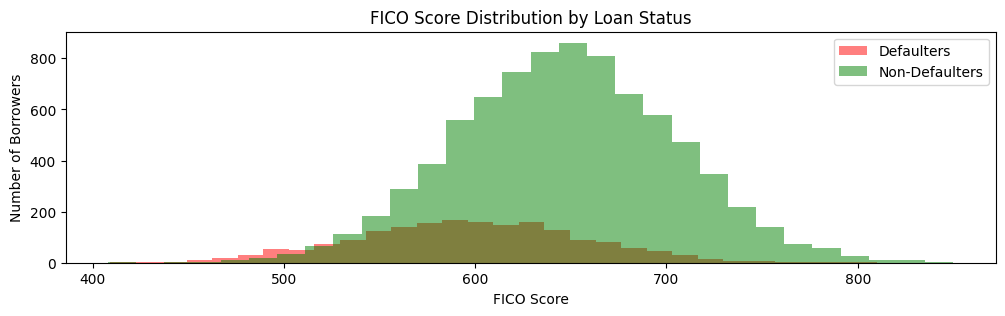

In [5]:
# Visualize FICO score distribution by default
plt.figure(figsize=(12, 3))
plt.hist(df[df['default'] == 1]['fico_score'], bins=30, alpha=0.5, label='Defaulters', color='red')
plt.hist(df[df['default'] == 0]['fico_score'], bins=30, alpha=0.5, label='Non-Defaulters', color='green')
plt.xlabel('FICO Score')
plt.ylabel('Number of Borrowers')
plt.title('FICO Score Distribution by Loan Status')
plt.legend()
plt.show()

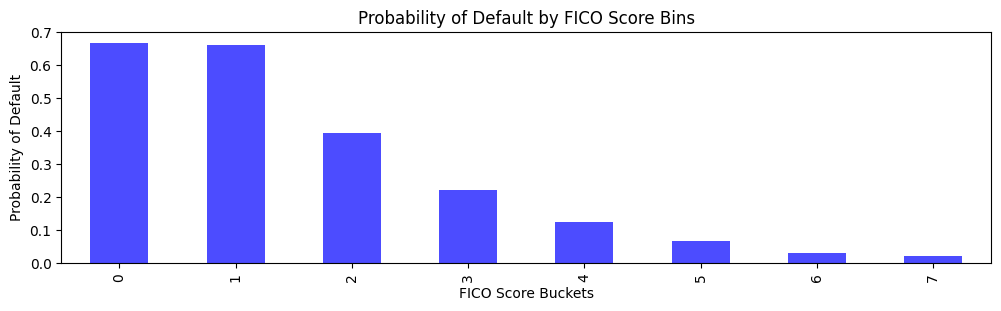

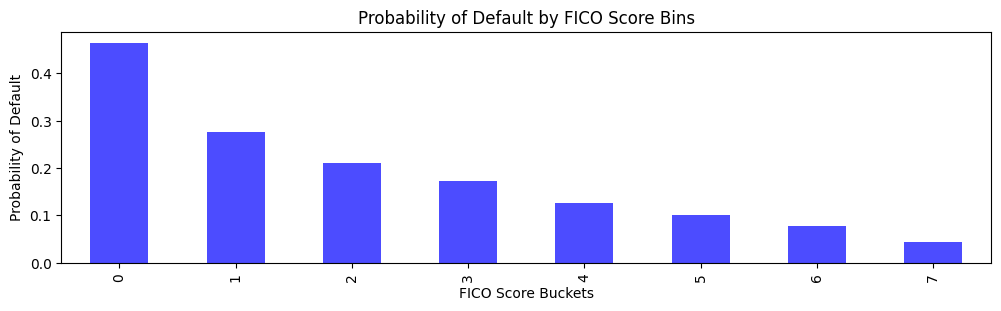

In [14]:
# Baseline quantization
n_buckets = 8

# Equal-width bucketing
fico_buckets = pd.cut(df['fico_score'], bins=n_buckets, labels=False)
avg_default_prob = df.groupby(fico_buckets, observed=True)['default'].mean()
plt.figure(figsize=(12, 3))
avg_default_prob.plot(kind='bar', color='blue', alpha=0.7)
plt.xlabel('FICO Score Buckets')
plt.ylabel('Probability of Default')
plt.title('Probability of Default by FICO Score Bins')
plt.show()

# Equal-frequency bucketing
fico_buckets = pd.qcut(df['fico_score'], q=n_buckets, labels=False)
avg_default_prob = df.groupby(fico_buckets, observed=True)['default'].mean()
plt.figure(figsize=(12, 3))
avg_default_prob.plot(kind='bar', color='blue', alpha=0.7)
plt.xlabel('FICO Score Buckets')
plt.ylabel('Probability of Default')
plt.title('Probability of Default by FICO Score Bins')
plt.show()

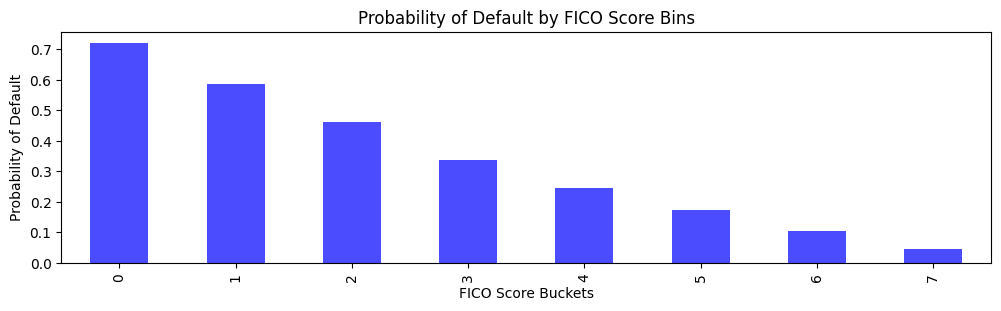

In [15]:
def supervised_bucketing(fico_scores, defaults, n_buckets):
    model = DecisionTreeClassifier(max_leaf_nodes=n_buckets)
    model.fit(fico_scores.reshape(-1, 1), defaults)
    boundaries = np.sort(model.tree_.threshold[model.tree_.threshold > 0])
    return boundaries

# Supervised bucketing
boundaries = supervised_bucketing(df['fico_score'].values, df['default'].values, n_buckets)
fico_buckets = np.digitize(df['fico_score'], bins=boundaries)
avg_default_prob = df.groupby(fico_buckets, observed=True)['default'].mean()
plt.figure(figsize=(12, 3))
avg_default_prob.plot(kind='bar', color='blue', alpha=0.7)
plt.xlabel('FICO Score Buckets')
plt.ylabel('Probability of Default')
plt.title('Probability of Default by FICO Score Bins')
plt.show()


Optimal thresholds: [np.float64(520.5), np.float64(552.5), np.float64(580.5), np.float64(611.5), np.float64(649.5), np.float64(696.5), np.float64(732.5)]


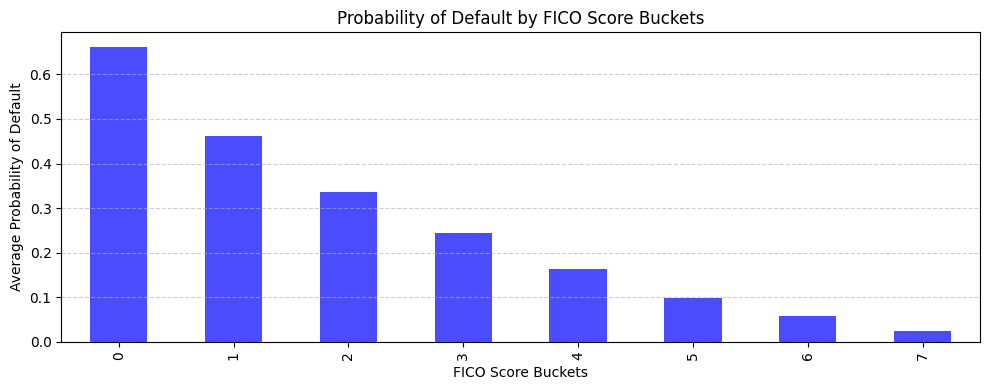

In [18]:
# Likelihood optimization
def log_likelihood(k, n, eps=1e-9):
    """Compute the log-likelihood of defaults given k defaults out of n."""
    p = np.clip(k / n, eps, 1 - eps)
    return k * np.log(p) + (n - k) * np.log(1 - p)

def optimal_binning_loglik(fico_score, default, n_bins):
    """
    Simple dynamic programming version (O(n_bins * U^2)) to find fico_score bucket boundaries
    maximizing total log-likelihood.
    """
    # Sort and group by unique scores
    df = pd.DataFrame({'fico_score': fico_score, 'default': default}).sort_values('fico_score')
    grouped = df.groupby('fico_score')['default'].agg(['count', 'sum']).reset_index()
    scores = grouped['fico_score'].values
    n = grouped['count'].values
    k = grouped['sum'].values
    U = len(scores)

    # cumulative sums
    cum_n = np.concatenate([[0], np.cumsum(n)])
    cum_k = np.concatenate([[0], np.cumsum(k)])

    # helper: log-likelihood of interval (i, j]
    def interval_ll(i, j):
        n_ij = cum_n[j] - cum_n[i]
        k_ij = cum_k[j] - cum_k[i]
        return log_likelihood(k_ij, n_ij)

    # DP arrays
    dp = np.full((n_bins + 1, U + 1), -np.inf)
    split = np.full((n_bins + 1, U + 1), -1)

    # base case: 1 bin
    for j in range(1, U + 1):
        dp[1, j] = interval_ll(0, j)

    # fill table
    for b in range(2, n_bins + 1):
        for j in range(b, U + 1):
            best_val, best_i = -np.inf, -1
            for i in range(b - 1, j):
                val = dp[b - 1, i] + interval_ll(i, j)
                if val > best_val:
                    best_val, best_i = val, i
            dp[b, j] = best_val
            split[b, j] = best_i

    # backtrack optimal boundaries
    boundaries_idx = []
    j, b = U, n_bins
    while b > 1:
        i = split[b, j]
        boundaries_idx.append(i)
        j, b = i, b - 1
    boundaries_idx = boundaries_idx[::-1]

    # convert to fico_score thresholds
    thresholds = [(scores[i-1] + scores[i]) / 2 for i in boundaries_idx]
    return thresholds


# Example usage and plotting
fico_score = df['fico_score'].values
default = df['default'].values

thresholds = optimal_binning_loglik(fico_score, default, n_bins=n_buckets)
print("Optimal thresholds:", thresholds)

bins = [-np.inf] + thresholds + [np.inf]
df = pd.DataFrame({'fico_score': fico_score, 'default': default})
df['bucket'] = pd.cut(df['fico_score'], bins=bins, labels=False)

avg_default_prob = df.groupby('bucket', observed=True)['default'].mean()

plt.figure(figsize=(10, 4))
avg_default_prob.plot(kind='bar', color='blue', alpha=0.7)
plt.xlabel('FICO Score Buckets')
plt.ylabel('Average Probability of Default')
plt.title('Probability of Default by FICO Score Buckets')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()